# Post-analysis code for Lightmap reconstruction simulations

### Import necessary libraries and create ReconLightmap object

This notebook uses the `ReconLightmap` class, defined in `AnalyzeLightmap.py`. After importing libraries and setting some plotting options, we start by initializing a `ReconLightmap` object to hold all our reconstructed lightmap data.

All the datasets used in this notebook, and many additional datasets, are described in this spreadsheet:
https://docs.google.com/spreadsheets/d/1V4Xc_nr0AnFcUhZVGxpQaf6Cn7eKVQsSS1gl9a2LdFg/edit?usp=sharing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import pandas as pd
import pickle
import gzip
import time
import histlite as hl
import sys
sys.path.insert(0,'/g/g92/hardy27/nexo-offline/nexo-offline/LightMap/python/')
sys.path.insert(0,'/g/g92/hardy27/Xe127Simulation/')
import Lightmap.AnalyzeLightmap as AL
from Lightmap.plot_data import proj2d
import LightMap

# set plotting style
plt.rc('figure', dpi=200, figsize=(6,4), facecolor='w')
plt.rc('savefig', dpi=200, facecolor='w')
plt.rc('lines', linewidth=1.5)
%matplotlib inline

# specify the folder where all the lightmap data is stored
folder = '/p/lustre2/nexouser/hardy27/xe127_sims/outputs/'

# initialize a reconstructed lightmap object to hold all the data
recon = AL.ReconLightmap(folder)

### Loading and saving raw data

We start by loading the raw data into the `ReconLightmap` object. This is done by specifying a range of filenames. In this case filenames look like `nn_123` for Neural Net file 123 and `ks_456` for Kernel Smoothing file 456. The full dataframe containing all the raw data will be pickled and saved so that the process of loading the data from each individual file does not have to be repeated each time the notebook is run.

In [2]:
# load the two sets of data separately and pickle raw dataframe
start = time.time()
recon.load_datasets('nn_',1,703)
recon.load_datasets('ks_',1,317)
recon.save_dataframe('raw','all_data_mar2025.pkl')
print('Finished in {:.1f} seconds'.format(time.time()-start))

Found 703 datasets
Raw data loaded and added to dataframe
Found 317 datasets
Raw data loaded and added to dataframe


/g/g92/hardy27/Xe127Simulation/Lightmap/AnalyzeLightmap.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.raw_data = pd.concat([self.raw_data,results],ignore_index=True,sort=False)


Dataframe saved to /p/lustre2/nexouser/hardy27/xe127_sims/outputs/all_data_mar2025.pkl
Finished in 257.0 seconds


With an empty `ReconLightmap` object, we can load the previously-saved raw dataframe.

In [3]:
# load the previously pickled dataframe of all raw data
start = time.time()
recon.load_dataframe('raw','all_data_mar2025.pkl')
print('Finished in {:.1f} seconds'.format(time.time()-start))
recon.print_columns()

Loaded dataframe from /p/lustre2/nexouser/hardy27/xe127_sims/outputs/all_data_mar2025.pkl
Finished in 35.1 seconds
The dataframe has the following columns:
name
fit_type
nominal_events
num_peaks
layers
learning_rate
ensemble_size
batch_size
sigma
num_events
times
losses
accuracy_std_dev
accuracy_mean
fid_cut
val_losses
hist_true
hist_again
hist_true_uniform
hist_again_uniform


## Hyperparameter tuning data

In the next few cells, we plot data with a number of lightmap reconstruction hyperparameters varied, to study their effect on the accuracy of the reconstructed lightmap. For neural net lightmap objects, these are the neural net hyperparameters, and we judge the accuracy of the reconstruction both by the lightmap error and by the training loss. For kernel smoothing lightmap objects, our only parameter is the smoothing length, and since there is no training loss, the reconstucted accuracy is assessed based on the lightmap error.

Since the quality of the neural net lightmap is highly dependent on the learning rate, for each set of data considered, the parameter of interest is scanned over for for four different learning rates. It turns out that the highest and lowest learning rates chosen given very bad results, so for the sake of clarity, only results for the middle two learning rates are plotted. The larger remaining learning rate, while not nearly as bad as the two extreme values, nonetheless does not give very good results. For this reason, we should pay more attention to what the lines plotted in the lighter colors are showing, as these give a better sense of how the neural net will perform when not limited by a poor choice of learning rate.

### Note on the data used in this notebook

This study of the lightmap reconstruction hyperparameters was done before the reconstruction methods were finalized, and as a result, the study is incomplete in some ways. All the lightmap reconstruction parameters considered below were tested both without any fiducial cut and with a 20mm fiducial cut. This was done when the true lightmap was slighly mismatched to the Geant4 geometry, meaning that there are thin bands at the anode and cathode where the photon transport efficiency is changes sharply. When this portion is not cut out by a fiducial cut, the lightmap is reconstructed very poorly. For this reason, only the data with a fiducial cut applied is considered below.

### Number of layers in the neural net

Here we start by varying the number of layers in the neural net, to test the hypothesis that the lightmap reconstruction improves with more layers in the neural net.

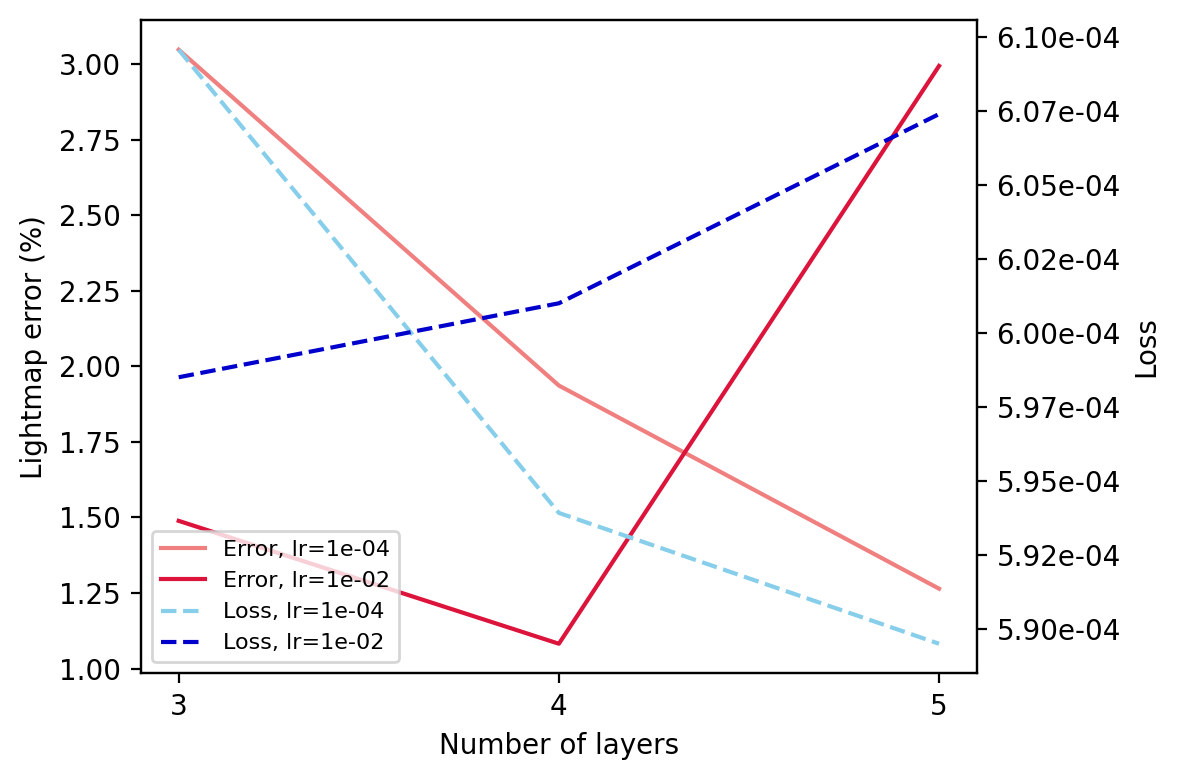

In [4]:
# define series of data with varied NN layers
layers_1 = ['nn_57','nn_58','nn_59']
layers_2 = ['nn_60','nn_61','nn_62']
layers_3 = ['nn_63','nn_64','nn_65']
layers_4 = ['nn_66','nn_67','nn_68']

# get error from data
layers_err_1 = recon.get_param_array(layers_1,'accuracy_std_dev')
layers_err_2 = recon.get_param_array(layers_2,'accuracy_std_dev')
layers_err_3 = recon.get_param_array(layers_3,'accuracy_std_dev')
layers_err_4 = recon.get_param_array(layers_4,'accuracy_std_dev')

# get learning rate from data
layers_lr_1 = recon.get_param_array(layers_1,'learning_rate',which='first')
layers_lr_2 = recon.get_param_array(layers_2,'learning_rate',which='first')
layers_lr_3 = recon.get_param_array(layers_3,'learning_rate',which='first')
layers_lr_4 = recon.get_param_array(layers_4,'learning_rate',which='first')

# get number of layers from data
layers_num_1 = recon.get_param_array(layers_1,'layers',which='length')
layers_num_2 = recon.get_param_array(layers_2,'layers',which='length')
layers_num_3 = recon.get_param_array(layers_3,'layers',which='length')
layers_num_4 = recon.get_param_array(layers_4,'layers',which='length')

# get loss from data
layers_loss_1 = recon.get_param_array(layers_1,'losses',which='final_mean')
layers_loss_2 = recon.get_param_array(layers_2,'losses',which='final_mean')
layers_loss_3 = recon.get_param_array(layers_3,'losses',which='final_mean')
layers_loss_4 = recon.get_param_array(layers_4,'losses',which='final_mean')

# plot error and loss vs number of layers for different learning rates
fig,ax = plt.subplots()
layers_err_plt_2 = ax.plot(layers_num_2,100*layers_err_2,\
                           label='Error, lr={:.0e}'.format(layers_lr_2),color='lightcoral')
layers_err_plt_3 = ax.plot(layers_num_3,100*layers_err_3,\
                           label='Error, lr={:.0e}'.format(layers_lr_3),color='crimson')
ax2 = ax.twinx()
layers_loss_plt_2 = ax2.plot(layers_num_2,layers_loss_2,\
                             label='Loss, lr={:.0e}'.format(layers_lr_2),color='skyblue',ls='--')
layers_loss_plt_3 = ax2.plot(layers_num_3,layers_loss_3,\
                             label='Loss, lr={:.0e}'.format(layers_lr_3),color='mediumblue',ls='--')
ax.set_xlabel('Number of layers')
ax.set_ylabel('Lightmap error (%)')
ax.set_xticks([3,4,5])
ax2.set_ylabel('Loss')
lns = layers_err_plt_2+layers_err_plt_3+layers_loss_plt_2+layers_loss_plt_3
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs,loc='best',prop={'size': 8})
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.tight_layout()
plt.show()

### Number of nodes in the neural net

Now instead of looking at the number of layers, we consider the total number of nodes, with the number of layers fixed. Again, common sense tells us that increasing the number of nodes should increase the accuracy of the reconstructed lightmap (to a point).

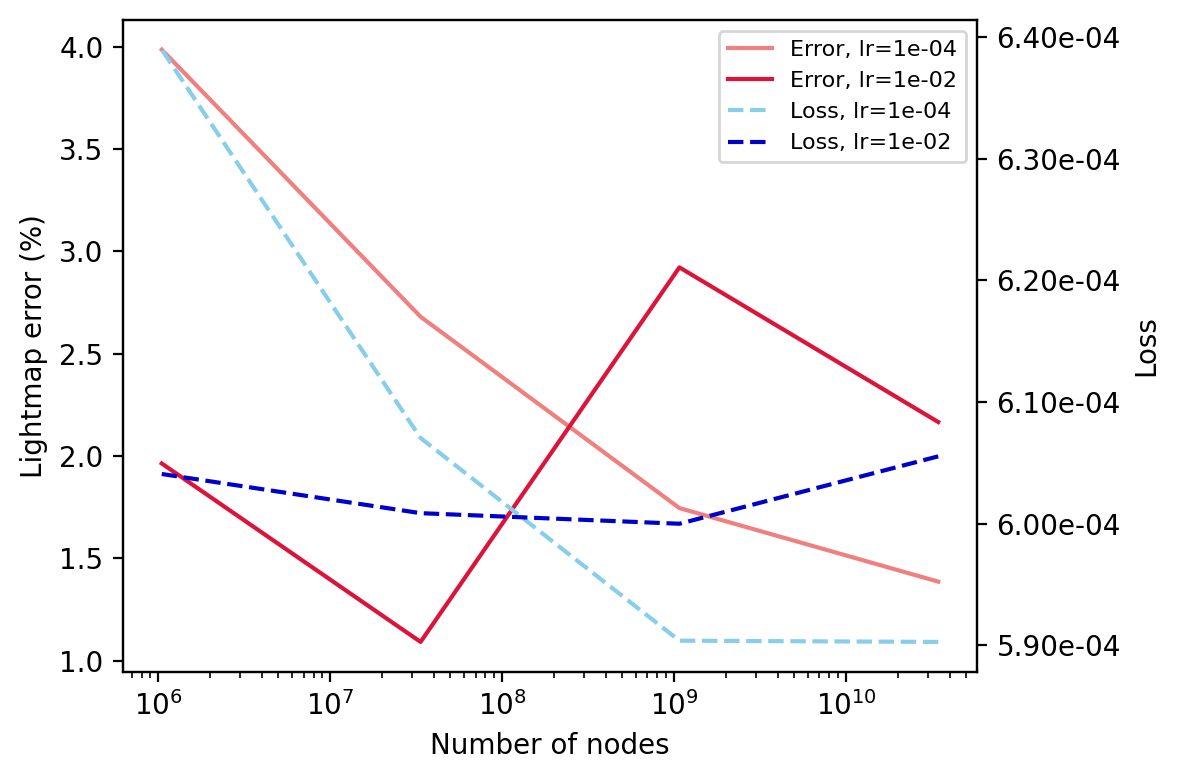

In [5]:
# define a series of data with varied number of nodes in NN
nodes_1 = ['nn_69','nn_70','nn_71','nn_72']
nodes_2 = ['nn_73','nn_74','nn_75','nn_76']
nodes_3 = ['nn_77','nn_78','nn_79','nn_80']
nodes_4 = ['nn_81','nn_82','nn_83','nn_84']

# get error from data
nodes_err_1 = recon.get_param_array(nodes_1,'accuracy_std_dev')
nodes_err_2 = recon.get_param_array(nodes_2,'accuracy_std_dev')
nodes_err_3 = recon.get_param_array(nodes_3,'accuracy_std_dev')
nodes_err_4 = recon.get_param_array(nodes_4,'accuracy_std_dev')

# get learning rate from data
nodes_lr_1 = recon.get_param_array(nodes_1,'learning_rate',which='first')
nodes_lr_2 = recon.get_param_array(nodes_2,'learning_rate',which='first')
nodes_lr_3 = recon.get_param_array(nodes_3,'learning_rate',which='first')
nodes_lr_4 = recon.get_param_array(nodes_4,'learning_rate',which='first')

# get number of nodes in NN from data
nodes_nodes_1 = recon.get_param_array(nodes_1,'layers',which='product')
nodes_nodes_2 = recon.get_param_array(nodes_2,'layers',which='product')
nodes_nodes_3 = recon.get_param_array(nodes_3,'layers',which='product')
nodes_nodes_4 = recon.get_param_array(nodes_4,'layers',which='product')

# get loss from data
nodes_loss_1 = recon.get_param_array(nodes_1,'losses',which='final_mean')
nodes_loss_2 = recon.get_param_array(nodes_2,'losses',which='final_mean')
nodes_loss_3 = recon.get_param_array(nodes_3,'losses',which='final_mean')
nodes_loss_4 = recon.get_param_array(nodes_4,'losses',which='final_mean')

# plot error and loss vs number of layers for different learning rates
fig,ax = plt.subplots()
nodes_err_plt_2 = ax.semilogx(nodes_nodes_2,100*nodes_err_2,\
                              label='Error, lr={:.0e}'.format(nodes_lr_2),color='lightcoral')
nodes_err_plt_3 = ax.semilogx(nodes_nodes_3,100*nodes_err_3,\
                              label='Error, lr={:.0e}'.format(nodes_lr_3),color='crimson')
ax2 = ax.twinx()
nodes_loss_plt_2 = ax2.semilogx(nodes_nodes_2,nodes_loss_2,\
                                label='Loss, lr={:.0e}'.format(nodes_lr_2),color='skyblue',ls='--')
nodes_loss_plt_3 = ax2.semilogx(nodes_nodes_3,nodes_loss_3,\
                                label='Loss, lr={:.0e}'.format(nodes_lr_3),color='mediumblue',ls='--')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Lightmap error (%)')
ax2.set_ylabel('Loss')
lns = nodes_err_plt_2+nodes_err_plt_3+nodes_loss_plt_2+nodes_loss_plt_3
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs,loc='best',prop={'size': 8})
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.tight_layout()
plt.show()

### Batch size

Now we look at the batch size used during training. While this has an impact on the lightmap error, it is also highly relevant for determining the time taken to train the neural net. There is timing information available in the raw data, but for now it is not plotted here.

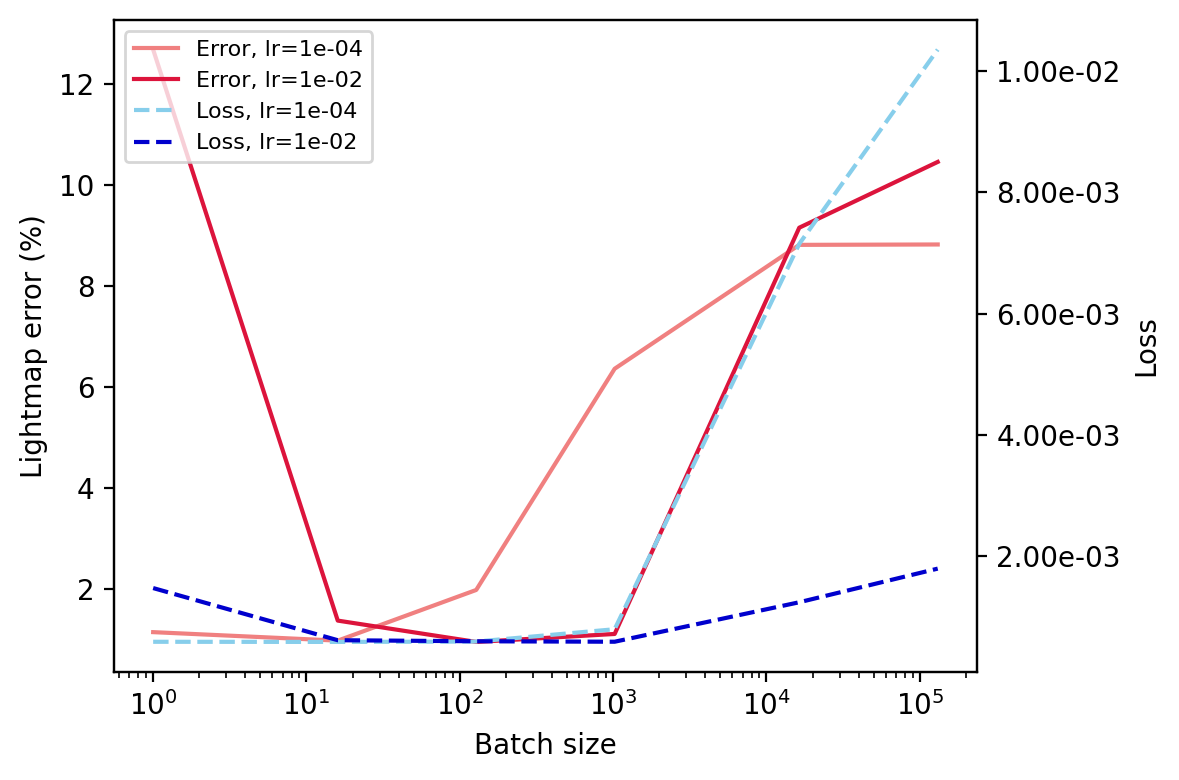

In [6]:
# define a series of data with varied batch size
bs_1 = ['nn_85','nn_86','nn_87','nn_88','nn_89','nn_90']
bs_2 = ['nn_91','nn_92','nn_93','nn_94','nn_95','nn_96']
bs_3 = ['nn_97','nn_98','nn_99','nn_100','nn_101','nn_102']
bs_4 = ['nn_103','nn_104','nn_105','nn_106','nn_107','nn_108']

# get error from data
bs_err_1 = recon.get_param_array(bs_1,'accuracy_std_dev')
bs_err_2 = recon.get_param_array(bs_2,'accuracy_std_dev')
bs_err_3 = recon.get_param_array(bs_3,'accuracy_std_dev')
bs_err_4 = recon.get_param_array(bs_4,'accuracy_std_dev')

# get learning rate from data
bs_lr_1 = recon.get_param_array(bs_1,'learning_rate',which='first')
bs_lr_2 = recon.get_param_array(bs_2,'learning_rate',which='first')
bs_lr_3 = recon.get_param_array(bs_3,'learning_rate',which='first')
bs_lr_4 = recon.get_param_array(bs_4,'learning_rate',which='first')

# get batch size from data
bs_bs_1 = recon.get_param_array(bs_1,'batch_size')
bs_bs_2 = recon.get_param_array(bs_2,'batch_size')
bs_bs_3 = recon.get_param_array(bs_3,'batch_size')
bs_bs_4 = recon.get_param_array(bs_4,'batch_size')

# get loss from data
bs_loss_1 = recon.get_param_array(bs_1,'losses',which='final_mean')
bs_loss_2 = recon.get_param_array(bs_2,'losses',which='final_mean')
bs_loss_3 = recon.get_param_array(bs_3,'losses',which='final_mean')
bs_loss_4 = recon.get_param_array(bs_4,'losses',which='final_mean')

# plot error and loss vs batch size for different learning rates
fig,ax = plt.subplots()
bs_err_plt_2 = ax.semilogx(bs_bs_2,100*bs_err_2,label='Error, lr={:.0e}'.format(bs_lr_2),color='lightcoral')
bs_err_plt_3 = ax.semilogx(bs_bs_3,100*bs_err_3,label='Error, lr={:.0e}'.format(bs_lr_3),color='crimson')
ax2 = ax.twinx()
bs_loss_plt_2 = ax2.semilogx(bs_bs_2,bs_loss_2,label='Loss, lr={:.0e}'.format(bs_lr_2),color='skyblue',ls='--')
bs_loss_plt_3 = ax2.semilogx(bs_bs_3,bs_loss_3,label='Loss, lr={:.0e}'.format(bs_lr_3),color='mediumblue',ls='--')
ax.set_xlabel('Batch size')
ax.set_ylabel('Lightmap error (%)')
ax2.set_ylabel('Loss')
lns = bs_err_plt_2+bs_err_plt_3+bs_loss_plt_2+bs_loss_plt_3
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs,loc='best',prop={'size': 8})
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.tight_layout()
plt.show()

### Ensemble size

The weights and biases of the neural net are initially randomized before training begins. For each dataset, this randomization-trianing process happens three times, and the final result is the average of the three training sessions. To see how the number of retrainings (or "ensemble size") affects the result, here this value is varied from one to ten. It's worth pointing out that the results here are often driven by outliers, or individual retrainings that deviate significantly from the others, and since the ensemble is so small, have a large impact on the final result.

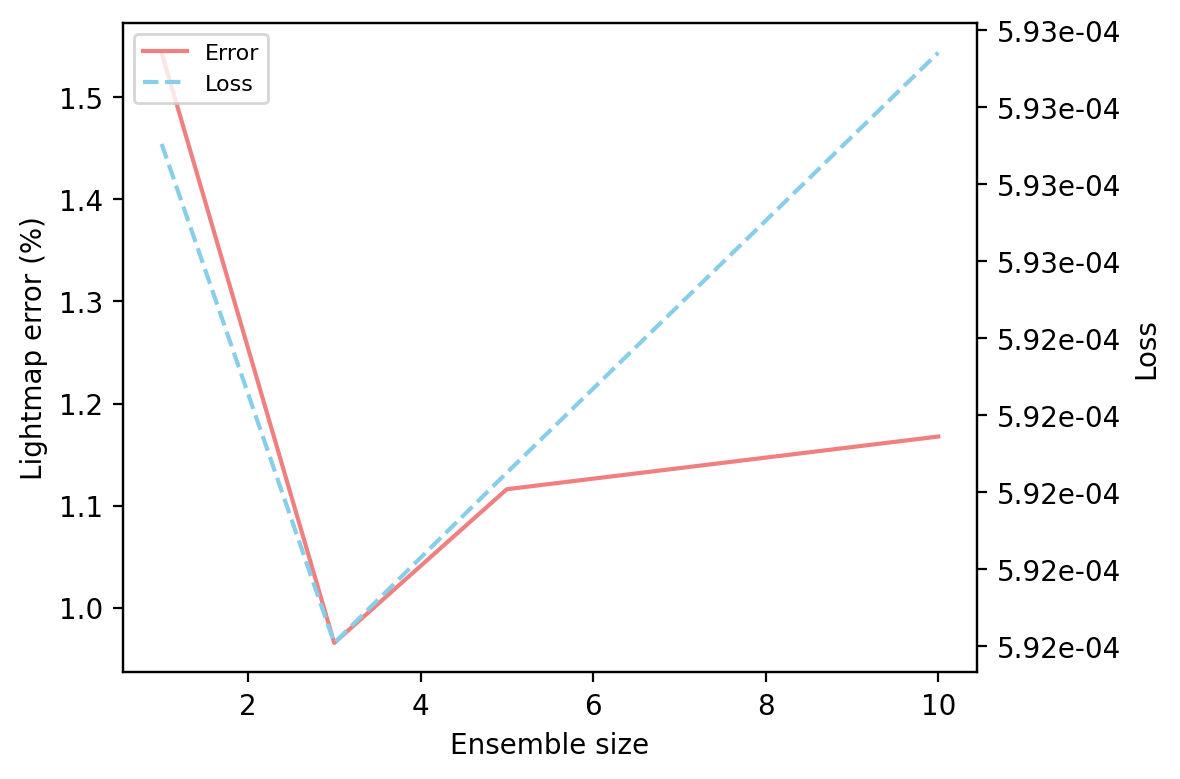

In [7]:
# define a series of data with varied ensemble size
ens_1 = ['nn_109','nn_110','nn_111','nn_112']

# get error from data
ens_err_1 = recon.get_param_array(ens_1,'accuracy_std_dev')

# get ensemble size from data
ens_size_1 = recon.get_param_array(ens_1,'ensemble_size')

# get loss from data
ens_loss_1 = recon.get_param_array(ens_1,'losses',which='final_mean')

# plot error and loss vs size of ensemble
fig,ax = plt.subplots()
ens_err_plt_1 = ax.plot(ens_size_1,100*ens_err_1,label='Error',color='lightcoral')
ax2 = ax.twinx()
ens_loss_plt_1 = ax2.plot(ens_size_1,ens_loss_1,label='Loss',color='skyblue',ls='--')
ax.set_xlabel('Ensemble size')
ax.set_ylabel('Lightmap error (%)')
ax2.set_ylabel('Loss')
lns = ens_err_plt_1+ens_loss_plt_1
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs,loc='best',prop={'size': 8})
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.tight_layout()
plt.show()

### Number of peaks and total number of events

Here we look at the scaling of the lightmap error with the total number of events in the training datasets. These numbers are different from the nominal dataset sizes (such as ten thousand events) because they reflect the true number of events passed to the neural net after all selection cuts have been applied. Since the neural net is trained on data from one of the two Xe127 peaks at a time, this data also shows the effect of choosing one peak over the other. Some of the cuts were tweaked following the simulation in which this data was produced, so the results are not final, but this code still gives a framework that can be used in the future if new data is substituted in.

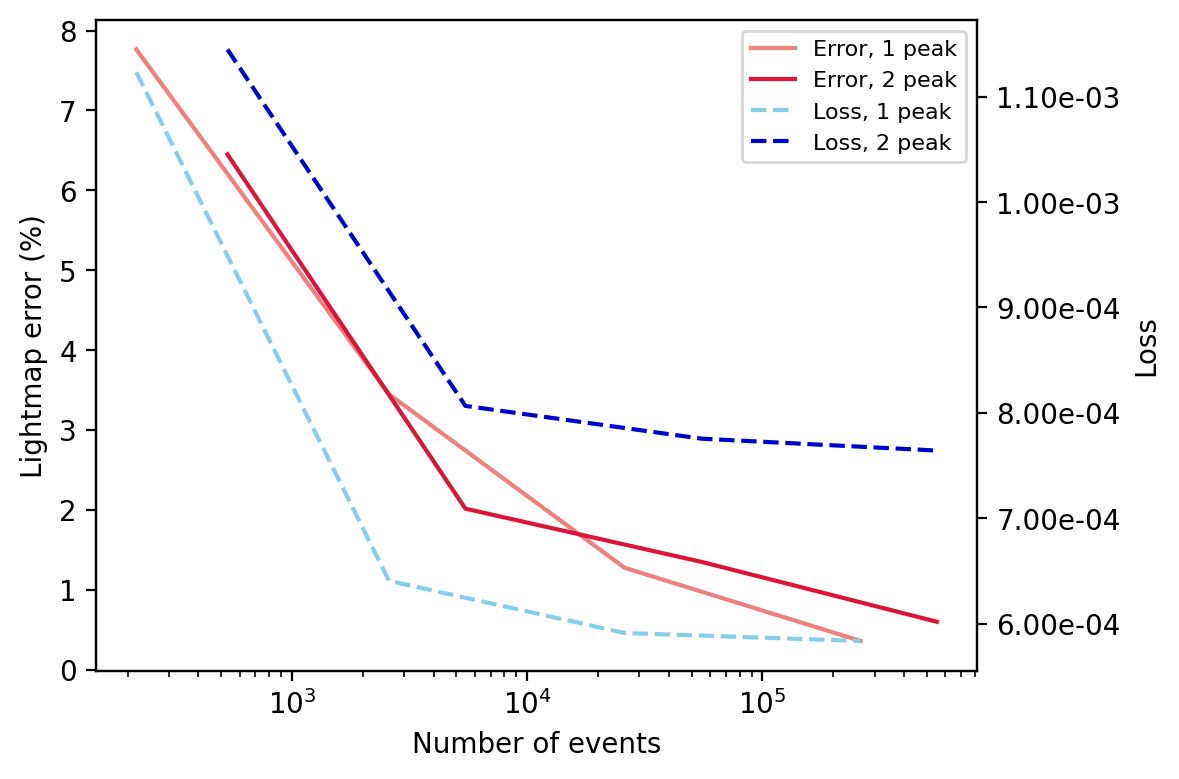

In [8]:
# define a series with varied number of peaks
peaks_1 = ['nn_121','nn_122','nn_123','nn_124']
peaks_2 = ['nn_125','nn_126','nn_127','nn_128']

# get error from data
peaks_err_1 = recon.get_param_array(peaks_1,'accuracy_std_dev')
peaks_err_2 = recon.get_param_array(peaks_2,'accuracy_std_dev')

# get number of events from data
peaks_nevt_1 = recon.get_param_array(peaks_1,'num_events')
peaks_nevt_2 = recon.get_param_array(peaks_2,'num_events')

# get number of peaks from data
peaks_peaks_1 = recon.get_param_array(peaks_1,'num_peaks',which='first')
peaks_peaks_2 = recon.get_param_array(peaks_2,'num_peaks',which='first')

# get losses from data
peaks_loss_1 = recon.get_param_array(peaks_1,'losses',which='final_mean')
peaks_loss_2 = recon.get_param_array(peaks_2,'losses',which='final_mean')

# plot error and loss vs number of events
fig,ax = plt.subplots()
peaks_err_plt_1 = ax.semilogx(peaks_nevt_1,100*peaks_err_1,\
                              label='Error, {:d} peak'.format(peaks_peaks_1),color='lightcoral')
peaks_err_plt_2 = ax.semilogx(peaks_nevt_2,100*peaks_err_2,\
                              label='Error, {:d} peak'.format(peaks_peaks_2),color='crimson')
ax2 = ax.twinx()
peaks_loss_plt_1 = ax2.semilogx(peaks_nevt_1,peaks_loss_1,\
                                label='Loss, {:d} peak'.format(peaks_peaks_1),color='skyblue',ls='--')
peaks_loss_plt_2 = ax2.semilogx(peaks_nevt_2,peaks_loss_2,\
                                label='Loss, {:d} peak'.format(peaks_peaks_2),color='mediumblue',ls='--')
ax.set_xlabel('Number of events')
ax.set_ylabel('Lightmap error (%)')
ax2.set_ylabel('Loss')
lns = peaks_err_plt_1+peaks_err_plt_2+peaks_loss_plt_1+peaks_loss_plt_2
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs,loc='best',prop={'size': 8})
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.tight_layout()
plt.show()

### Kernel smoothing length scale

Now we move on to the kernel smoothing parameters. This one is a fairly simple analysis that involves optimizing only a single parameter. We scan over a range of smoothing lengths and choose the one that gives the minimum lightmap error. Fortunately, the results are very predictable and make it easy to choose an appropriate smoothing parameter. Keep in mind that this smoothing parameter is a function of the dataset size so this optimization has to be done each time a new dataset size is chosen.

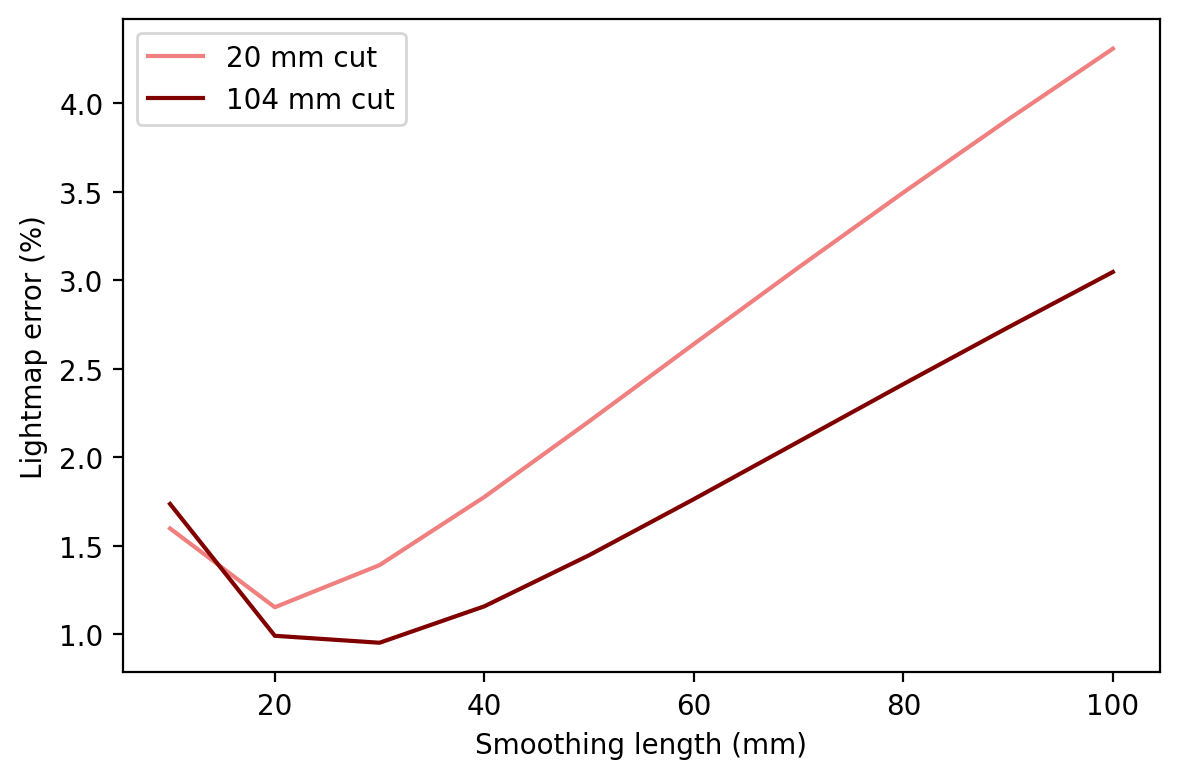

In [9]:
# define series of data with varied smoothing length
sigma_1 = []
sigma_2 = []
for i in range(10):
    sigma_1.append('ks_{:.0f}'.format(293+i))
    sigma_2.append('ks_{:.0f}'.format(303+i))

# get error from data
sigma_err_1 = recon.get_param_array(sigma_1,'accuracy_std_dev')
sigma_err_2 = recon.get_param_array(sigma_2,'accuracy_std_dev')

# get smoothing length from data
sigma_sigma_1 = recon.get_param_array(sigma_1,'sigma')
sigma_sigma_2 = recon.get_param_array(sigma_2,'sigma')

# plot error and loss vs smoothing length
fig,ax = plt.subplots()
sigma_plt_1 = ax.plot(sigma_sigma_1,100*sigma_err_1,label='20 mm cut',color='lightcoral')
sigma_plt_2 = ax.plot(sigma_sigma_2,100*sigma_err_2,label='104 mm cut',color='maroon')
plt.legend(loc='best')
ax.set_xlabel('Smoothing length (mm)')
ax.set_ylabel('Lightmap error (%)')
plt.tight_layout()
plt.show()

### Number of peaks and total number of events

The analysis that was done previously for the neural net is now repeated here for the kernel smoothing.

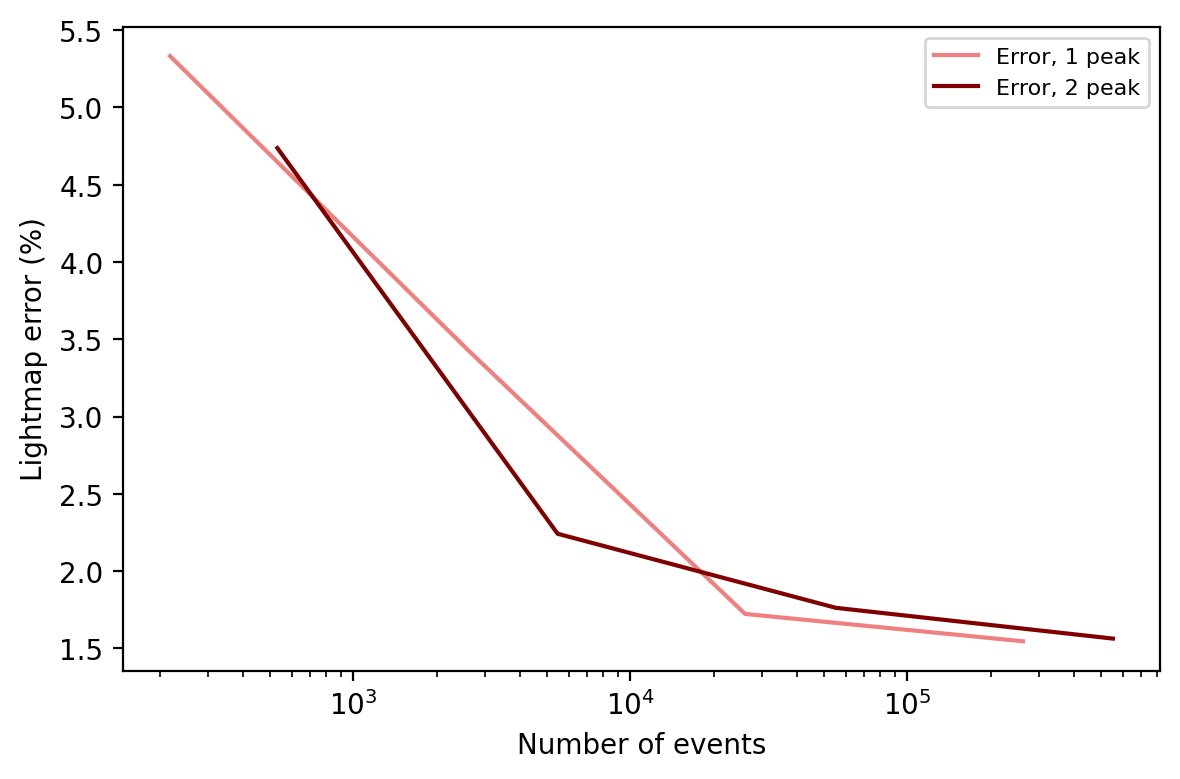

In [10]:
# define series with varied number of peaks
peaks_3 = ['ks_25','ks_26','ks_27','ks_28']
peaks_4 = ['ks_29','ks_30','ks_31','ks_32']

# get error from data
peaks_err_3 = recon.get_param_array(peaks_3,'accuracy_std_dev')
peaks_err_4 = recon.get_param_array(peaks_4,'accuracy_std_dev')

# get number of events from data
peaks_nevt_3 = recon.get_param_array(peaks_3,'num_events')
peaks_nevt_4 = recon.get_param_array(peaks_4,'num_events')

# get number of peaks from data
peaks_peaks_3 = recon.get_param_array(peaks_3,'num_peaks',which='first')
peaks_peaks_4 = recon.get_param_array(peaks_4,'num_peaks',which='first')

# plot error and loss vs number of events
fig,ax = plt.subplots()
peaks_plt_3 = ax.semilogx(peaks_nevt_3,100*peaks_err_3,\
                          label='Error, {:d} peak'.format(peaks_peaks_3),color='lightcoral')
peaks_plt_4 = ax.semilogx(peaks_nevt_4,100*peaks_err_4,\
                          label='Error, {:d} peak'.format(peaks_peaks_4),color='maroon')
ax.set_xlabel('Number of events')
ax.set_ylabel('Lightmap error (%)')
ax.legend(loc='best',prop={'size': 8})
plt.tight_layout()
plt.show()

### Loss and learning rate

Here we look at how the learning rate affects the convergence of the neural net, by showing both the training loss vs the epoch and the final error vs the training loss. This analysis was done after the studies in the previous cells and was used to determine the final learning rate used in the lightmap training. The analysis in the previous cells could be repeated with the proper learning rate value for the sake of confirming that the results are true and not reflecting limitations of a poor learning rate.

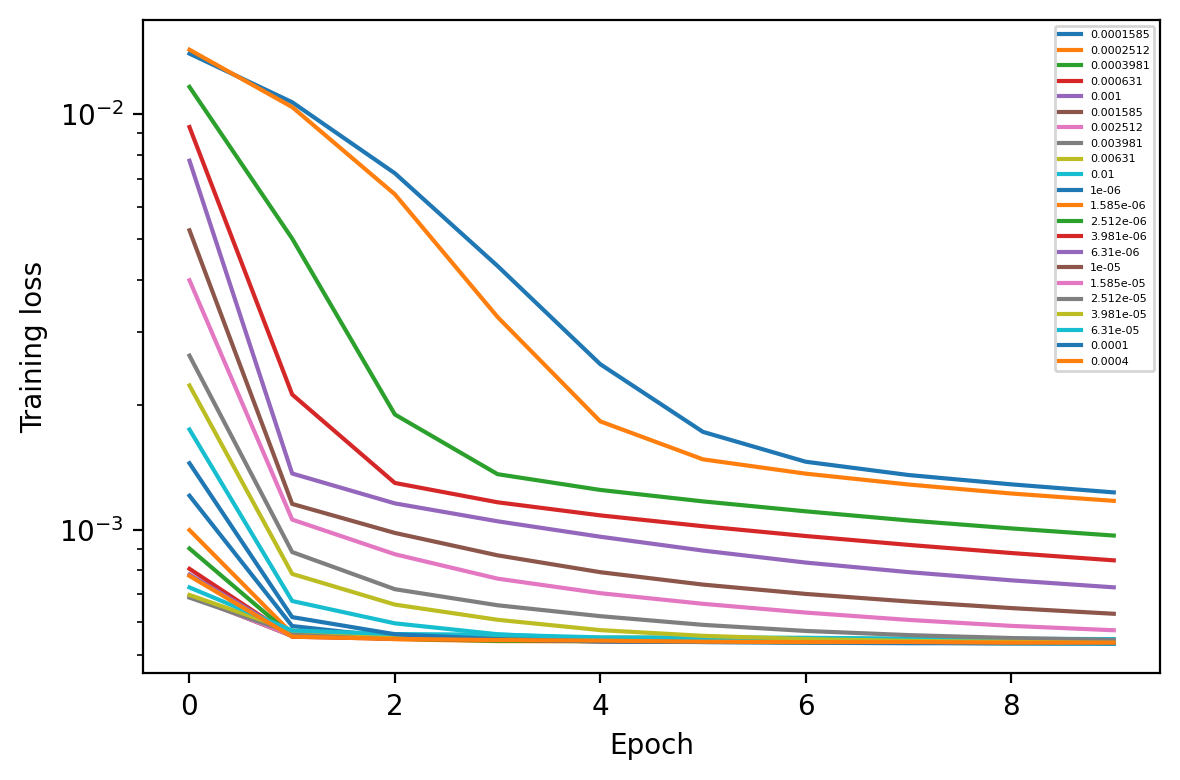

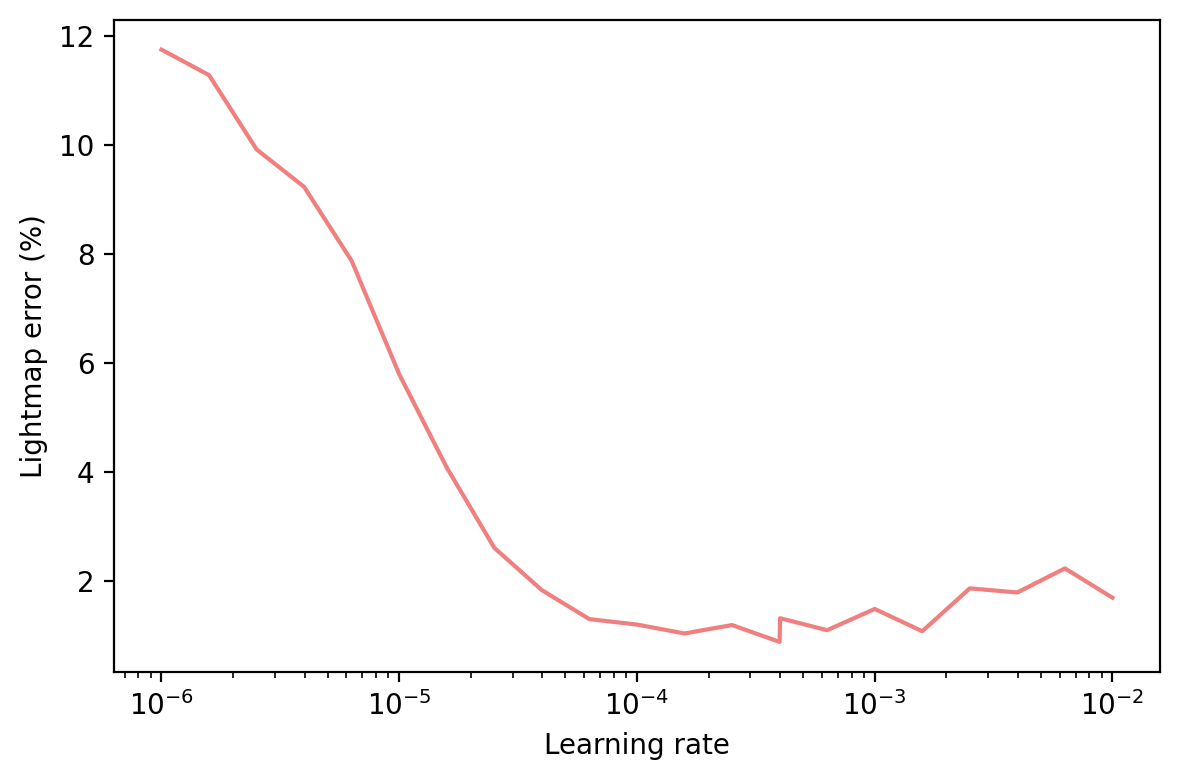

In [11]:
# plot the training loss vs epoch for a range of learning rates
fig,ax = plt.subplots()
train_errs_1 = []
train_lrs_1 = []
for i in range(22):
    epoch_1 = ['nn_{:.0f}'.format(130+i)]
    epoch_err_1 = recon.get_param_array(epoch_1,'accuracy_std_dev')
    epoch_lr_1 = recon.get_param_array(epoch_1,'learning_rate',which='first')
    train_errs_1.append(epoch_err_1)
    train_lrs_1.append(epoch_lr_1)
    epoch_loss_1 = recon.get_param_array(epoch_1,'losses',which='running_mean')
    ax.semilogy(epoch_loss_1,label=str(epoch_lr_1))

# plotting parameters
ax.legend(loc='best',prop={'size': 4})
ax.set_xlabel('Epoch')
ax.set_ylabel('Training loss')
plt.tight_layout()
plt.show()

# sort the arrays
train_errs_1 = np.array([x for _, x in sorted(zip(train_lrs_1,train_errs_1))])
train_lrs_1 = sorted(train_lrs_1)

# plot error vs learning rate
fig,ax = plt.subplots()
ax.semilogx(train_lrs_1,100*np.array(train_errs_1),color='lightcoral')
ax.set_xlabel('Learning rate')
ax.set_ylabel('Lightmap error (%)')
# plt.savefig('learning_rate.png',bbox_inches='tight')
plt.tight_layout()
plt.show()

### Validation loss

This cell shows the ratio of the validation loss to training loss vs the epoch for five datasets. This ratio is used for monitoring for overtraining: if the validation loss is much smaller than the training loss, the neural net is overtrained, whereas if it's larger, the neural net is undertrained. Since we're training on a representative sample of events taken from a larger population, it is unlikely that the neural net will be able to pick up on specifics of the training dataset and become overtrained. The plot below confirms this.

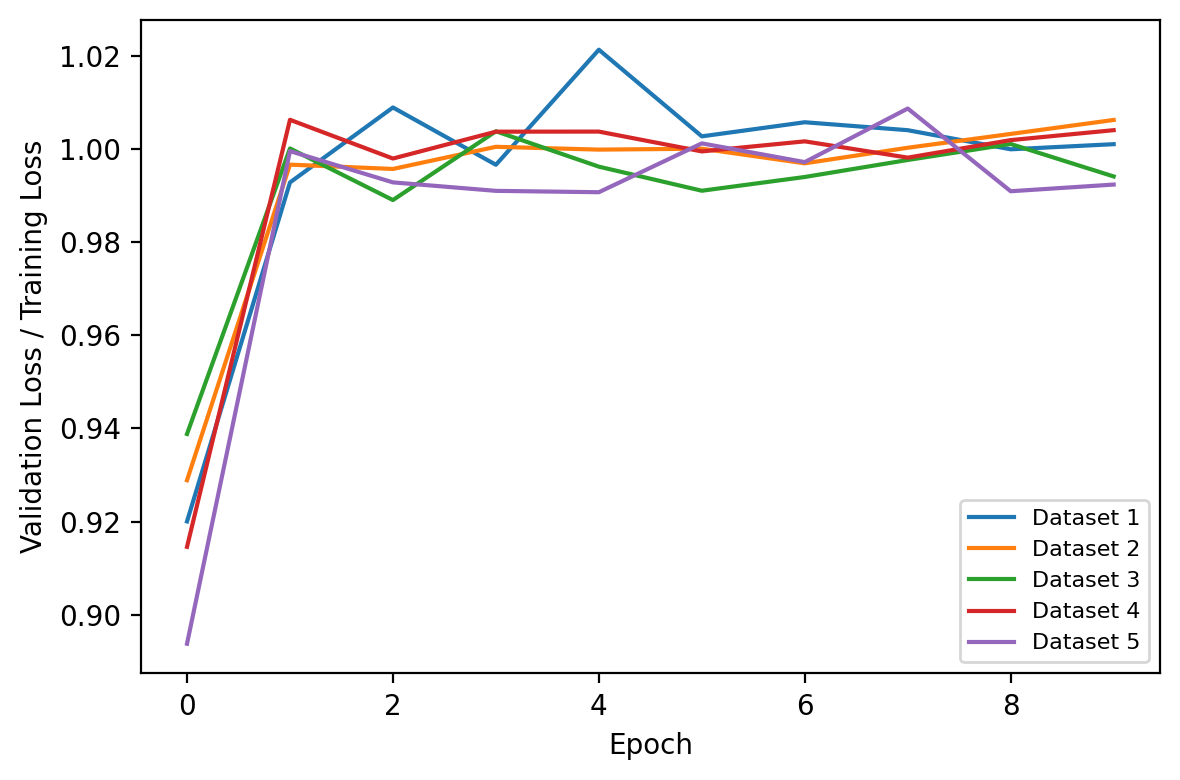

In [12]:
# plot ratio of validation loss to training loss vs epoch for 5 datasets
fig,ax = plt.subplots()
for i in range(5):
    epoch_2 = ['nn_{:.0f}'.format(574+i)]
    epoch_loss_2 = recon.get_param_array(epoch_2,'losses',which='running_mean')
    epoch_val_2 = recon.get_param_array(epoch_2,'val_losses',which='running_mean')
    ax.plot(epoch_val_2/epoch_loss_2,label='Dataset '+str(i+1))

# plotting parameters
ax.legend(loc='best',prop={'size': 8})
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss / Training Loss')
plt.tight_layout()
# fig.savefig('val_ratio.png',bbox_inches='tight')

### Batch size again

We return here to the batch size after having optimized the learning rate. This result gives a much clearer picture than above, but the takeaway is largely the same: within a fairly large range of batch sizes, the error is insensitive to the batch size.

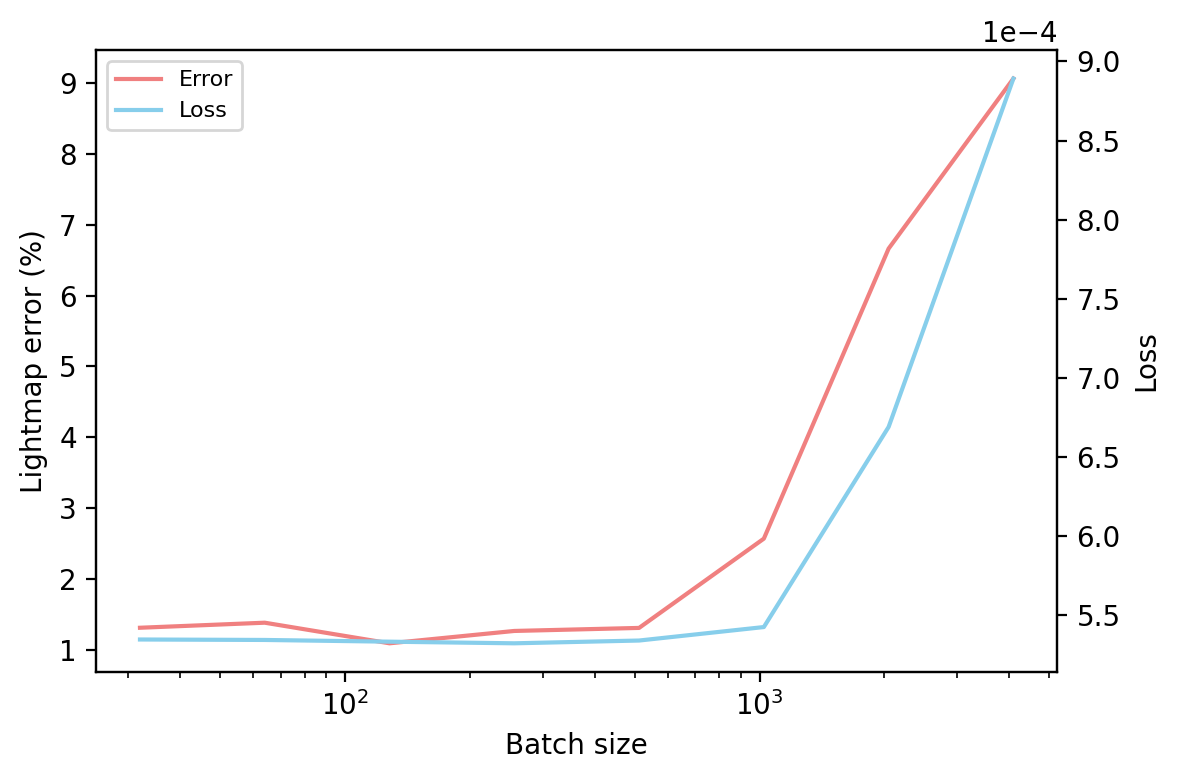

In [13]:
# define a series of datasets with varying batch size
bs_5 = []
for i in range(8):
    bs_5.append('nn_{:.0f}'.format(151+i))

# get error from data
bs_err_5 = recon.get_param_array(bs_5,'accuracy_std_dev')

# get batch size from data
bs_bs_5 = recon.get_param_array(bs_5,'batch_size')

# get loss from data
bs_loss_5 = recon.get_param_array(bs_5,'losses',which='final_mean')
    
# plot error and loss vs batch size
fig,ax = plt.subplots()
bs_err_plt_5 = ax.semilogx(bs_bs_5,100*bs_err_5,label='Error',color='lightcoral')
ax2 = ax.twinx()
ax2.yaxis.major.formatter.set_powerlimits((0,0))
bs_loss_plt_5 = ax2.semilogx(bs_bs_5,bs_loss_5,label='Loss',color='skyblue')
ax.set_xlabel('Batch size')
ax.set_ylabel('Lightmap error (%)')
ax2.set_ylabel('Loss')
lns = bs_err_plt_5+bs_loss_plt_5
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs,loc='best',prop={'size': 8})
# plt.savefig('batch_size.png',bbox_inches='tight')
plt.tight_layout()
plt.show()

## Final analysis to produce plots for the Xe127 paper

### Select the datasets to reduce for the final analysis

To avoid having to load the full raw dataset every time a plot is tweaked, we reduce a subset of the data and save it separately so it can be loaded later. This cell creates a list of strings representing the dataset names. This list can be passed to the reduction code to specify which data to reduce.

In this case, we put all datasets for the five nominal dataset sizes, each with 25 datasets, into the same list. When we eventually analyze this data point by point, we will divide the data up into the five subsets. Since the 500k event subset was added after the fact, the correction array is used to insert it into the correct place in the list.

In [4]:
# define series of datasets to reduce and recalculate error
correction = np.array([0,0,0,125,-25])
nevt_NN = []
for i in range(5):
    for j in range(25):
        nevt_NN.append('nn_{:.0f}'.format(479+j+25*i+correction[i]))

### Produce the reduced dataframe from the raw data and save it

Create new ReconLightmap objects and call the reduction function. The analysis code is written so that each object can have only a single raw dataframe and a single reduced dataframe. This means we need a new object for each reduced dataset. Here we have two reduced datasets, each recomputing the lightmap error with a different fiducial cut. The reduced data is computed from a raw dataframe contained in the "parent" lightmap object.

In [6]:
# reduce the data and recalculate the errors
recon_full = AL.ReconLightmap(folder)
recon_inner2 = AL.ReconLightmap(folder)
recon_full.reduce_raw_data(nevt_NN,parent=recon,recompute=True,fiducial_cut=20)
recon_inner2.reduce_raw_data(nevt_NN,parent=recon,recompute=True,fiducial_cut=104)

# pickle the reduced data
recon_full.save_dataframe('reduced','NN_full_volume.pkl')
recon_inner2.save_dataframe('reduced','NN_inner_2_tonnes.pkl')

Data reduced and added to dataframe
Data reduced and added to dataframe
[10.71777154 10.54869361 10.25221662  9.78000967  9.96199524  9.55361248
 10.56623221 11.63159252 10.55870137 10.20947462 10.67095947  9.75861273
 11.25925175  9.49450964 10.28718941  9.77334686  9.91847548 10.50880961
 10.53690962 11.79549862  9.98929612 10.51264552 10.18816882  9.98550197
  9.90192819  2.6924754   2.72827446  2.94891875  2.94334004  3.06391887
  2.90970239  3.7823852   3.31419951  2.66098293  2.99324112  2.83666408
  2.38937311  2.80448075  2.8413222   2.89026383  2.75712865  2.72366688
  2.92103192  3.04813093  3.17775264  3.20502671  3.61131707  2.51323041
  2.84507959  2.71000743  1.28993987  1.24536873  1.09383975  1.35772334
  1.36248331  1.11181393  1.46415054  1.39818199  1.58690739  1.00992212
  1.03135184  1.34323503  1.09491169  1.26671289  1.20189091  2.16361901
  1.11932139  1.51146142  1.20979203  1.47423765  1.21448931  1.03291259
  1.15583284  1.33752971  1.05975383  0.74654585  0.

### Load the dataframe containing the reduced data

This cell loads the data that was saved previously.

In [ ]:
# open the reduced data
start = time.time()
recon_full = AL.ReconLightmap(folder)
recon_inner2 = AL.ReconLightmap(folder)
recon_full.load_dataframe('reduced','NN_full_volume.pkl')
recon_inner2.load_dataframe('reduced','NN_inner_2_tonnes.pkl')
print('Finished in {:.1f} seconds'.format(time.time()-start))

Loaded dataframe from /p/lustre2/nexouser/hardy27/xe127_sims/outputs/NN_full_volume.pkl
Loaded dataframe from /p/lustre2/nexouser/hardy27/xe127_sims/outputs/NN_inner_2_tonnes.pkl
Finished in 0.0 seconds


### Make final result plot for the paper

This produces the final plot showing the lightmap error with respect to the nominal dataset size. This is where we take the list containing all four nominal dataset sizes and split it up into the data used to make the four final points.

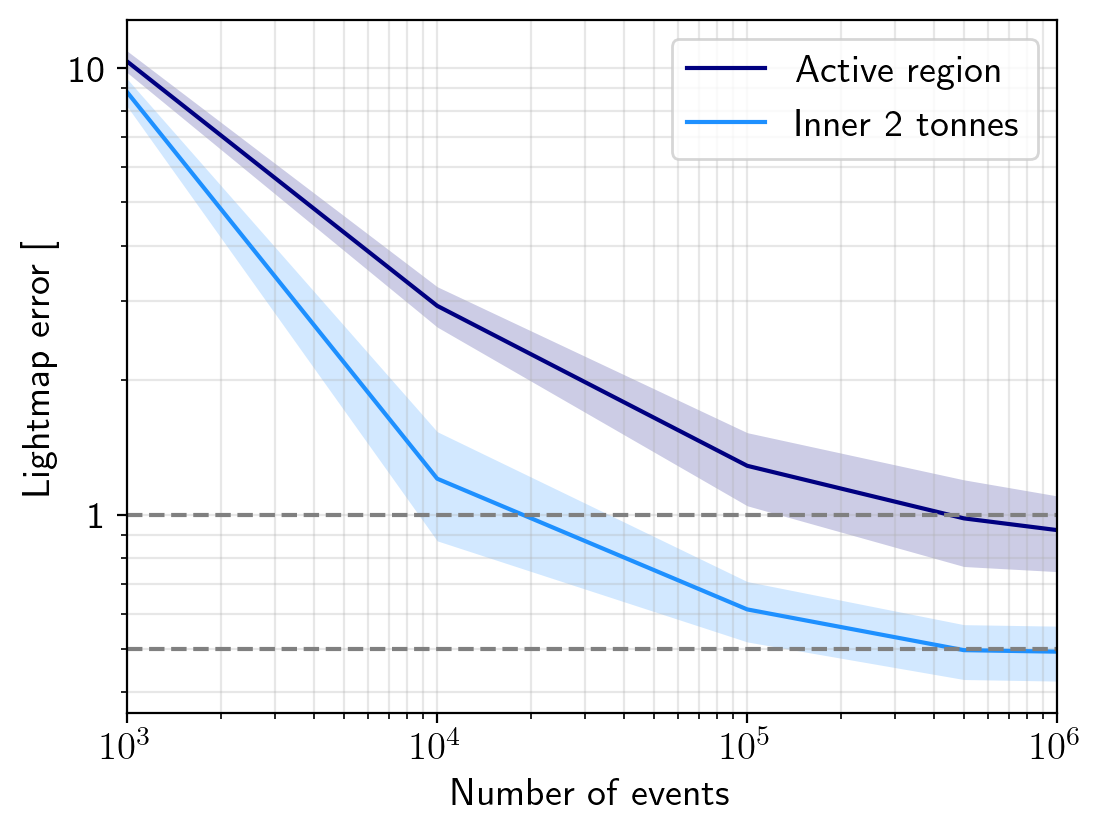

In [59]:
from scipy.interpolate import interp1d

# number of events for each datapoint
num_evts = np.array([1e3,1e4,1e5,1e6,5e5])

# get error from data
nevt_full_err = recon_full.get_value_array(nevt_NN,'error')
nevt_inner2_err = recon_inner2.get_value_array(nevt_NN,'error')

# compute average error and error bars at each point
full_error_mean = []
full_error_plus1s = []
full_error_minus1s = []
inner2_error_mean = []
inner2_error_plus1s = []
inner2_error_minus1s = []
for i in range(5):
    full_array = nevt_full_err[25*i:25*(i+1)]
    inner2_array = nevt_inner2_err[25*i:25*(i+1)]
    full_error_mean.append(np.mean(full_array))
    full_error_plus1s.append(np.mean(full_array)+np.std(full_array))
    full_error_minus1s.append(np.mean(full_array)-np.std(full_array))
    inner2_error_mean.append(np.mean(inner2_array))
    inner2_error_plus1s.append(np.mean(inner2_array)+np.std(inner2_array))
    inner2_error_minus1s.append(np.mean(inner2_array)-np.std(inner2_array))

# convert to numpy arrays
full_error_mean = np.array([x for _, x in sorted(zip(num_evts, full_error_mean))])
full_error_plus1s = np.array([x for _, x in sorted(zip(num_evts, full_error_plus1s))])
full_error_minus1s = np.array([x for _, x in sorted(zip(num_evts, full_error_minus1s))])
inner2_error_mean = np.array([x for _, x in sorted(zip(num_evts, inner2_error_mean))])
inner2_error_plus1s = np.array([x for _, x in sorted(zip(num_evts, inner2_error_plus1s))])
inner2_error_minus1s = np.array([x for _, x in sorted(zip(num_evts, inner2_error_minus1s))])
num_evts = np.array(sorted(num_evts))

# linear interpolation for smooth energy resolution calculation
li_full = interp1d(np.log(num_evts),np.log(full_error_mean),kind='linear')
li_inner2 = interp1d(np.log(num_evts),np.log(inner2_error_mean),kind='linear')
log_evts_interp = np.linspace(np.log(num_evts[0]),np.log(num_evts[-1]),100)
num_evts_interp = np.exp(log_evts_interp)
full_error_fit = np.exp(li_full(log_evts_interp))
inner2_error_fit = np.exp(li_inner2(log_evts_interp))

# save the data for this plot so it can be loaded and replotted for my thesis
np.savez('lm_error_vs_num_events.npz', num_evts=num_evts, full_error_mean=full_error_mean, full_error_minus1s=full_error_minus1s, \
                                       full_error_plus1s=full_error_plus1s, inner2_error_mean=inner2_error_mean, inner2_error_minus1s=inner2_error_minus1s, \
                                       inner2_error_plus1s=inner2_error_plus1s, allow_pickle=False)

# plot the result
fig,ax = plt.subplots(figsize=(6,4.5))
ax.loglog(num_evts,full_error_mean*100,label='Active region',color='navy')
ax.fill_between(num_evts,full_error_minus1s*100,full_error_plus1s*100,alpha=0.2,color='navy',linewidth=0.0)
ax.loglog(num_evts,inner2_error_mean*100,label='Inner 2 tonnes',color='dodgerblue')
ax.fill_between(num_evts,inner2_error_minus1s*100,inner2_error_plus1s*100,alpha=0.2,\
                color='dodgerblue',linewidth=0.0)
ax.set_ylabel('Lightmap error [%]',fontsize=14)
ax.set_xlabel('Number of events',fontsize=14)
ax.set_xlim([1e3,1e6])
ax.legend(loc='best',prop={'size': 14})
ax.axhline(1.,ls='--',color='gray')
ax.axhline(0.5,ls='--',color='gray')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both',alpha=0.3)
# fig.savefig('lightmap_result.png',bbox_inches='tight')
plt.show()

### Define energy resolution as a function of lightmap error

This function calculates the energy resolution from the lightmap error by adding the additional lightmap error contribution to the nominal nEXO energy resolution from the 2021 sensitivity paper.

In [6]:
def FudgedEnergyResolutionAtQFromEL( lm_error ):
    F = 0.06 # Fano factor
    quanta_avg = 2458*1000/11.5
    Qavg = 115419 # electrons at 0nu Q value
    drift = 696./2. # average drift time
    chnoise = 1132 # electrons
    Lavg = 98320. # photons at 0nu Q-value
    collectioneff = 0.062 # light collection efficiency
    lam = 0.2 # correlated avalanche probability
    DC = 23.
    eta = 0.
    sigma_lm = 0.005
    lifetime = 10000.
    relative_term = (0.008)**2 * quanta_avg**2 - Lavg**2 * sigma_lm**2
    resolution = np.sqrt( relative_term +\
                         Lavg**2 * lm_error**2
                        ) / quanta_avg
    return resolution

### Make energy resolution plot for paper

Plot the energy resolution as a function of the calibration time.

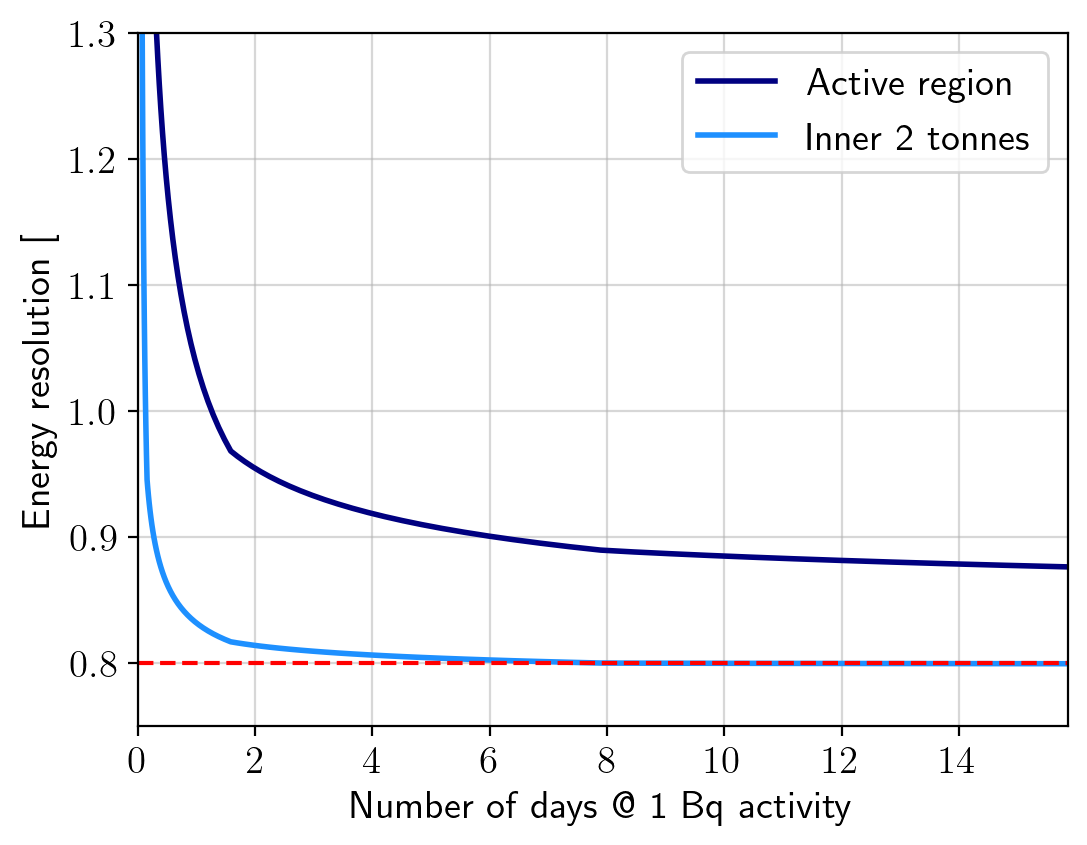

In [60]:
# calculate energy resolution from lightmap error
Eres_full_fit = 100*FudgedEnergyResolutionAtQFromEL(full_error_fit)
Eres_full_mean = 100*FudgedEnergyResolutionAtQFromEL(full_error_mean)
Eres_full_plus1s = 100*FudgedEnergyResolutionAtQFromEL(full_error_plus1s)
Eres_full_minus1s = 100*FudgedEnergyResolutionAtQFromEL(full_error_minus1s)
Eres_inner2_fit = 100*FudgedEnergyResolutionAtQFromEL(inner2_error_fit)
Eres_inner2_mean = 100*FudgedEnergyResolutionAtQFromEL(inner2_error_mean)
Eres_inner2_plus1s = 100*FudgedEnergyResolutionAtQFromEL(inner2_error_plus1s)
Eres_inner2_minus1s = 100*FudgedEnergyResolutionAtQFromEL(inner2_error_minus1s)

# calculate calibration time from activity
TPC_frac = 0.73 # fraction of the xenon in the TPC at one time
activity = 1. # Bq
cal_time = num_evts*activity/TPC_frac/3600./24. # calibration time in days
cal_time_interp = num_evts_interp*activity/TPC_frac/3600./24. # calibration time in days

# save the data for this plot so it can be loaded and replotted for my thesis
np.savez('eres_vs_calibration_time.npz', cal_time_interp=cal_time_interp, Eres_full_fit=Eres_full_fit, \
                                         Eres_inner2_fit=Eres_inner2_fit, allow_pickle=False)

# plot energy resolution vs calibration time
fig,ax = plt.subplots(figsize=(6,4.5))
ax.plot(cal_time_interp,Eres_full_fit,label='Active region',color='navy',lw=2)
ax.plot(cal_time_interp,Eres_inner2_fit,label='Inner 2 tonnes',color='dodgerblue',lw=2)
#ax.fill_between(cal_time,Eres_full_minus1s,Eres_full_plus1s,alpha=0.2,color='navy',linewidth=0.0)
#ax.fill_between(cal_time,Eres_inner2_minus1s,Eres_inner2_plus1s,alpha=0.2,color='dodgerblue',linewidth=0.0)
ax.axhline(0.8,color='red',ls='--')
ax.set_xlabel('Number of days @ 1 Bq activity',fontsize=14)
ax.set_ylabel('Energy resolution [%]',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks([0,2,4,6,8,10,12,14])
ax.grid(alpha=0.5)
ax.set_ylim([0.75,1.3])
ax.set_xlim([0,max(cal_time)])
ax.legend(loc='best',prop={'size': 14})
# fig.savefig('energy_resolution_lightmap.png',bbox_inches='tight')

plt.show()

### Load some histograms for plotting and pickle them

In this part we take advantage of the `ReconLightmap` method that allows for individual properties of a dataset to be returned, and get the raw histograms. Most of the analysis that requires access to these histograms should live in the `ReconLightmap` class, but in this case we access them directly to use them for plotting. This cell gets the histograms and then pickles them.

In [9]:
# choose the first dataset at each point to plot
plotting_sets = []
for i in range(4):
    plotting_sets.append(nevt_NN[25*i])

# get the histograms for these datasets
hists_true = recon.get_param_array(plotting_sets,'hist_true')
hists_true_uniform = recon.get_param_array(plotting_sets,'hist_true_uniform')
hists_again = recon.get_param_array(plotting_sets,'hist_again')
hists_again_uniform = recon.get_param_array(plotting_sets,'hist_again_uniform')
standoffs = recon.get_param_array(plotting_sets,'fid_cut')

# pickle the hists
pickle.dump((hists_true,hists_again,hists_true_uniform,hists_again_uniform,standoffs),\
            open('../plotting_hists.pkl','wb'))

### Load the pickled histograms

Load the histograms pickled in the previous cell.

In [14]:
# load the pickled hists for plotting
hists_true,hists_again,hists_true_uniform,hists_again_uniform,standoffs\
= pickle.load(open('../plotting_hists.pkl','rb'))

### Create a plot showing lightmap reconstruction for sample datasets

This cell creates a grid of the reconstructed lightmap accuracy for four datasets, one of each nominal size.

/var/tmp/hardy27/ipykernel_333354/3009921206.py:75: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


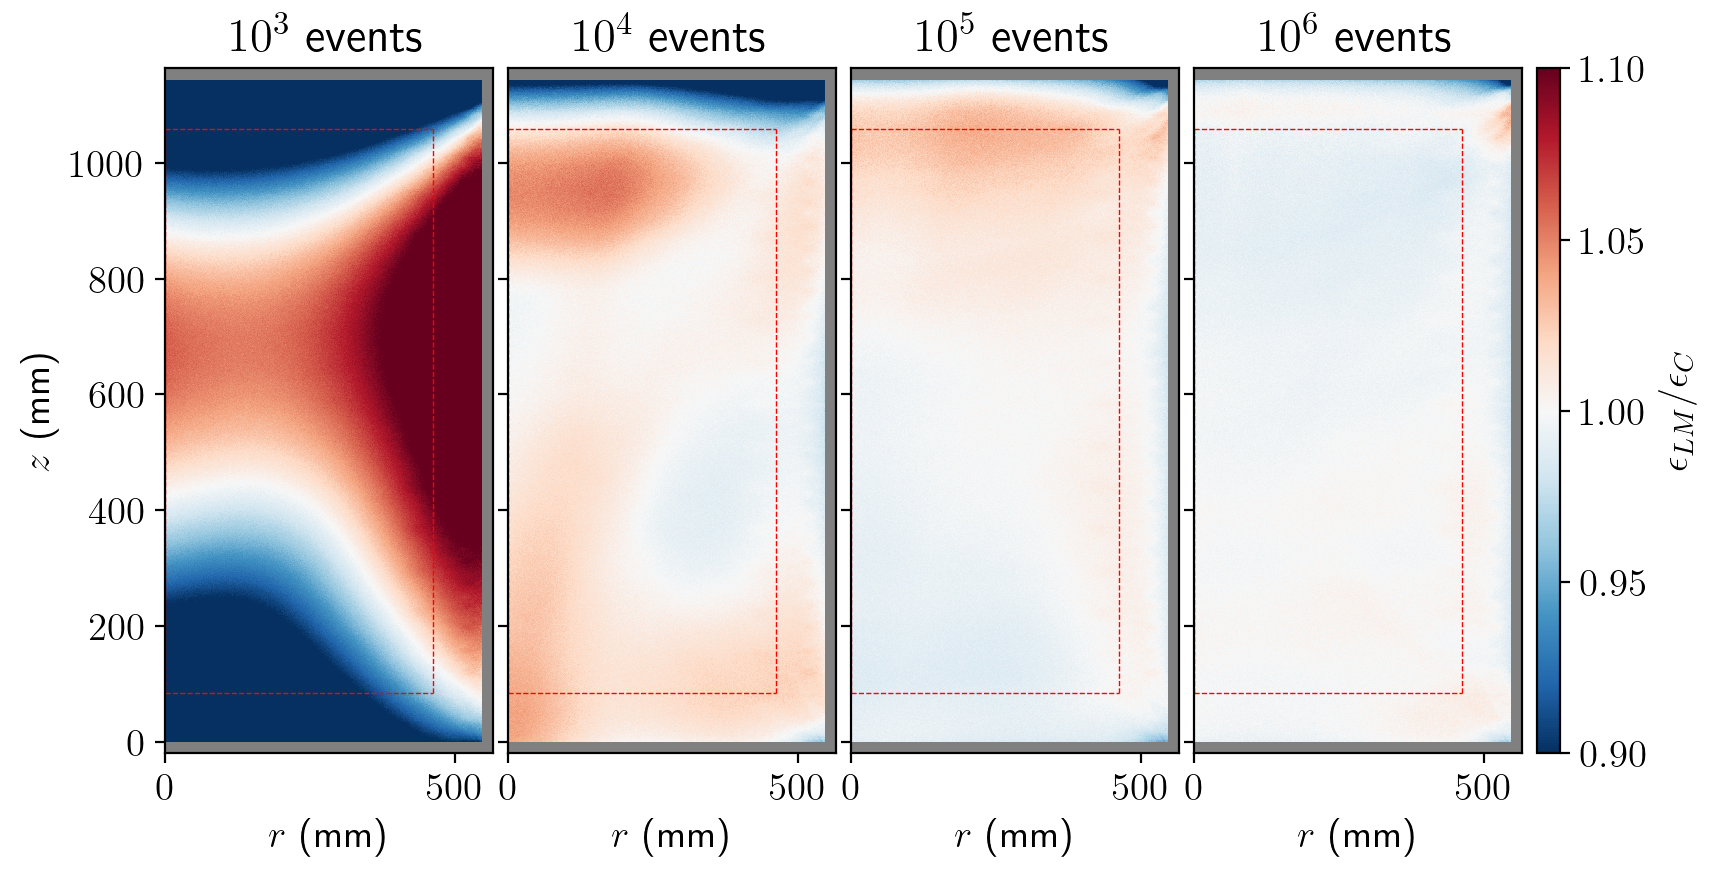

In [ ]:
# render text nicely
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["text.usetex"] =True
plt.rcParams.update({'font.size': 14})

# save the data for this plot so it can be loaded and replotted for my thesis
np.savez('lm_error_hist_panels.npz', true_lm_r_bins_1k=hists_true[0].bins[0], true_lm_z_bins_1k=hists_true[0].bins[1], true_lm_eff_1k=hists_true[0].values.T, \
                                     true_lm_r_bins_10k=hists_true[1].bins[0], true_lm_z_bins_10k=hists_true[1].bins[1], true_lm_eff_10k=hists_true[1].values.T, \
                                     true_lm_r_bins_100k=hists_true[2].bins[0], true_lm_z_bins_100k=hists_true[2].bins[1], true_lm_eff_100k=hists_true[2].values.T, \
                                     true_lm_r_bins_1m=hists_true[3].bins[0], true_lm_z_bins_1m=hists_true[3].bins[1], true_lm_eff_1m=hists_true[3].values.T, \
                                     recon_lm_r_bins_1k=hists_again[0].bins[0], recon_lm_z_bins_1k=hists_again[0].bins[1], recon_lm_eff_1k=hists_again[0].values.T, \
                                     recon_lm_r_bins_10k=hists_again[1].bins[0], recon_lm_z_bins_10k=hists_again[1].bins[1], recon_lm_eff_10k=hists_again[1].values.T, \
                                     recon_lm_r_bins_100k=hists_again[2].bins[0], recon_lm_z_bins_100k=hists_again[2].bins[1], recon_lm_eff_100k=hists_again[2].values.T, \
                                     recon_lm_r_bins_1m=hists_again[3].bins[0], recon_lm_z_bins_1m=hists_again[3].bins[1], recon_lm_eff_1m=hists_again[3].values.T, \
                                     allow_pickle=False)

# create a grid to show the results for different datasets
gridspec_kw = {'width_ratios':[1,1,1,1,]}
fig=plt.figure(figsize=(9,6))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,4),
                 axes_pad=0.075,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.075,
                 label_mode='L'
                 )

# compute offset to shift histogram to put cathode at z=0
offset = -hists_again[0].bins[1][0]

# plot titles
#titles = ['1k events','10k events','100k events','1M events']
titles = ['$10^3$ events','$10^4$ events','$10^5$ events','$10^6$ events']
# where to plot line showing inner volume
cut = 104
for j,ax in enumerate(grid):
    
    # shift the histograms to put z=0 at the cathode
    hists_again[j].bins[1] = hists_again[j].bins[1]+offset
    hists_true[j].bins[1] = hists_true[j].bins[1]+offset
    
    # compute where edges of the TPC are relative to hist limits
    rmin = hists_again[j].bins[0][0]
    rmax = hists_again[j].bins[0][-1]+standoffs[j]
    zmin = hists_again[j].bins[1][0]-standoffs[j]
    zmax = hists_again[j].bins[1][-1]+standoffs[j]
    
    # plot histogram
    d = hl.plot2d(ax, hists_true[j]/hists_again[j], cbar=False, cmap='RdBu_r',vmin=0.9,vmax=1.1)
    
    # plotting parameters
    ax.set_xlim([rmin,rmax])
    ax.set_ylim([zmin,zmax])
    ax.set_xlabel(r'$r$ (mm)')
    ax.set_aspect('equal')
    ax.set_title(titles[j])
    ax.set_facecolor('gray')
    
    # lines showing inner subvolume in the TPC
    ax.axvline(x=rmin,ymin=(cut)/(zmax-zmin),\
                ymax=(zmax-zmin-cut)/(zmax-zmin),color='red',ls='--',lw=0.5)
    ax.axvline(x=rmax-cut,ymin=(cut)/(zmax-zmin),\
                ymax=(zmax-zmin-cut)/(zmax-zmin),color='red',ls='--',lw=0.5)
    ax.axhline(y=zmin+cut,xmin=rmin/(rmax),xmax=(rmax-cut)/(rmax),color='red',ls='--',lw=0.5)
    ax.axhline(y=zmax-cut,xmin=rmin/(rmax),xmax=(rmax-cut)/(rmax),color='red',ls='--',lw=0.5)

# more plotting parameters
grid[0].set_ylabel(r'$z$ (mm)')
cbar = ax.cax.colorbar(d)
#cbar.set_label_text(r'True Lightmap / Reconstructed Lightmap')
cbar.set_label(r'$\epsilon_{LM}/\epsilon_{C}$')
# ax.cax.toggle_label(True)
# fig.savefig('lightmap_sample_accuracy.png',bbox_inches='tight')
plt.show()

### Distribution of reconstructed accuracy

Since it is clear from the previous cell that there are biases introduced into the reconstructed lightmap for small datasets, here we want to look at the effect this can have on the final result. The lightmap error term is simply the standard distribution of the true lightmap divided by the reconstructed lightmap point by point throughout the detector volume of interest. This plot allows us to see at which point the standard deviation of this distribution actually reflects something sensible.

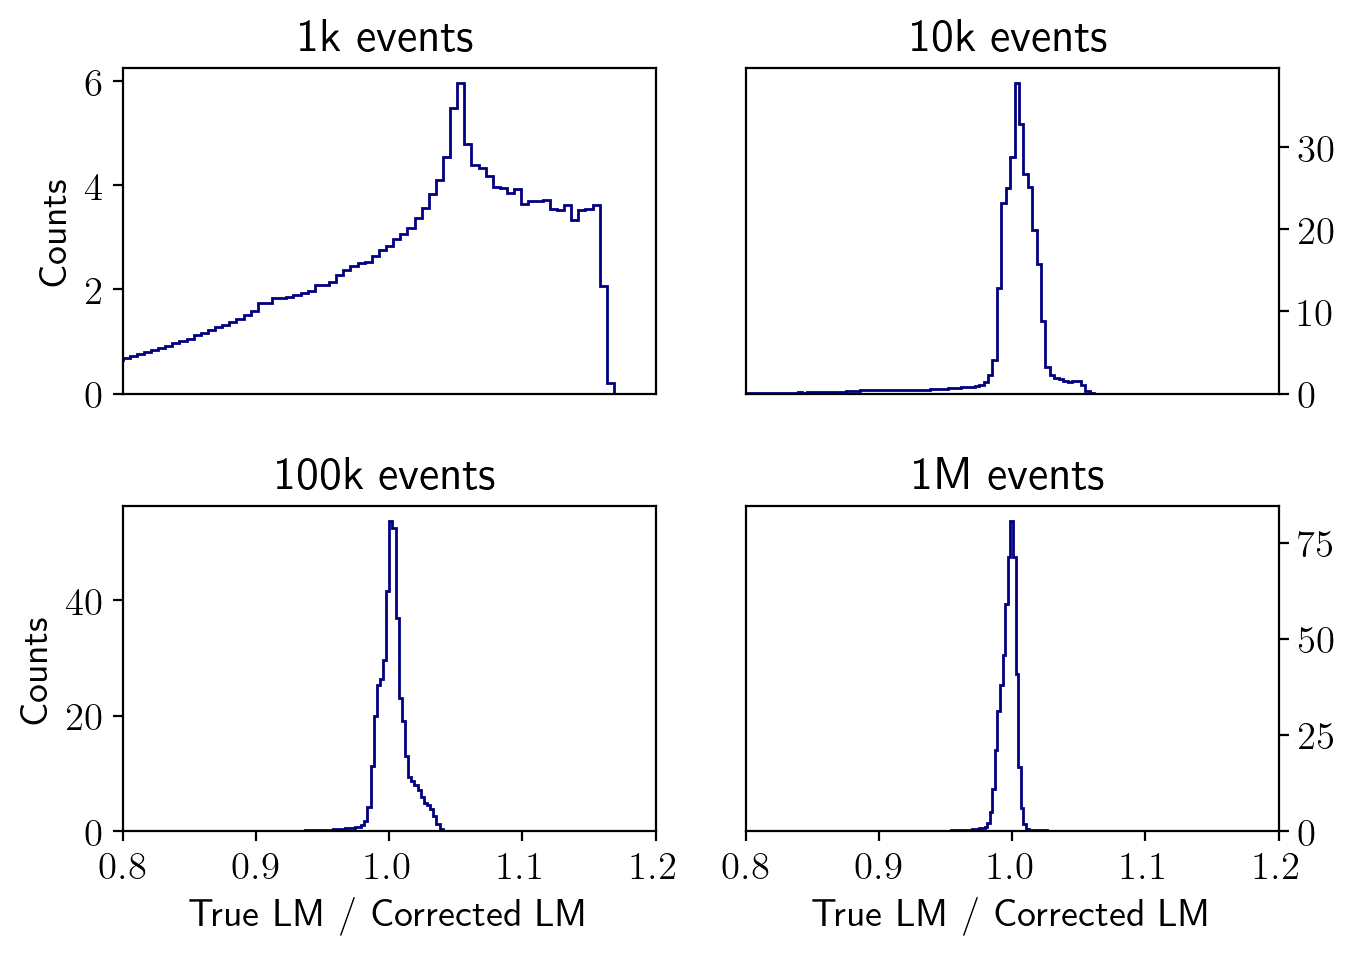

In [16]:
# plot labels saying how many events
evts = ['1k','10k','100k','1M']
# create a grid to show accuracy distributions
fig,ax = plt.subplots(2,2,figsize=(7,5))
for i in range(4):
    # compute the accuracy array to be histogrammed
    acc = np.ndarray.flatten(hists_true_uniform[i].values/hists_again_uniform[i].values)
    ax[int(np.floor(i/2))][i%2].hist(acc,bins=100,histtype=u'step',density=True,color='navy')
    ax[int(np.floor(i/2))][i%2].set_xlim([0.8,1.2])
    ax[int(np.floor(i/2))][i%2].set_title(evts[i]+' events')

    # set ticks and labels depending on position on grid
    if int(np.floor(i/2))==1:
        ax[i%2][int(np.floor(i/2))].yaxis.tick_right()
    else:
        ax[i%2][int(np.floor(i/2))].set_ylabel('Counts')
    if i%2==0:
        ax[i%2][int(np.floor(i/2))].set_xticks([])
    else:
        ax[i%2][int(np.floor(i/2))].set_xlabel('True LM / Corrected LM')

fig.subplots_adjust(wspace=0.05)
fig.tight_layout()
# fig.savefig('errs_inner.png',bbox_inches='tight')
plt.show()

## Energy resolution model

In case it's needed to see how these results propagate to the energy resolution, here is a function that implements the full energy resolution model.

In [17]:
def EnergyResolutionAtQFromLM( sigma_lm ):
    F = 0.06 # Fano factor
    quanta_avg = 2458*1000/11.5
    Qavg = 115419 # electrons at 0nu Q value
    drift = 696./2. # average drift time
    chnoise = 1132 # electrons
    Lavg = 98320. # photons at 0nu Q-value
    collectioneff = 0.062 # light collection efficiency
    lam = 0.2 # correlated avalanche probability
    DC = 23.
    eta = 0.
    lifetime = 10000.
    fractional_error = 0.1/lifetime
    resolution = np.sqrt( \
                        F * quanta_avg + \
                         Qavg * drift / lifetime + \
                         Qavg**2*(2*drift/np.sqrt(3))**2*fractional_error**2 +\
                         chnoise**2/np.exp(-drift/lifetime)**2 +\
                         Lavg/collectioneff * ( (1-collectioneff) + lam/(1+lam**2)) +\
                         (DC + eta)/(collectioneff**2*(1+lam)**2) +\
                         Lavg**2 * sigma_lm**2
                        ) / quanta_avg
    print('Fano: {:4.4}'.format(np.sqrt(F*quanta_avg)))
    print('Lifetime: {:4.4}'.format(np.sqrt(Qavg * drift/lifetime)))
    print('Lifetime error: {:4.4}'.format(np.sqrt(Qavg**2*(2*drift/np.sqrt(3))**2*fractional_error**2)))
    print('Charge noise: {:4.4}'.format(np.sqrt(chnoise**2/np.exp(-drift/lifetime)**2)))
    print('Collection noise: {:4.4}'.format(np.sqrt(Lavg/collectioneff * ( (1-collectioneff) + lam/(1+lam**2)))))
    print('Light noise: {:4.4}'.format(np.sqrt((DC + eta)/(collectioneff**2*(1+lam)**2))))
    print('Lightmap: {:4.4}'.format(np.sqrt(Lavg**2 * sigma_lm**2)))
    return resolution

### Simulation to reconstruction pipeline for sample dataset

This plot shows the true lightmap from which calibration data is sampled, the calibration events, and then the lightmap as reconstructed by the calibration data.

/var/tmp/hardy27/ipykernel_333354/4014992869.py:57: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use ax.tick_params and colorbar.set_label instead.
  grid[2].cax.toggle_label(True)


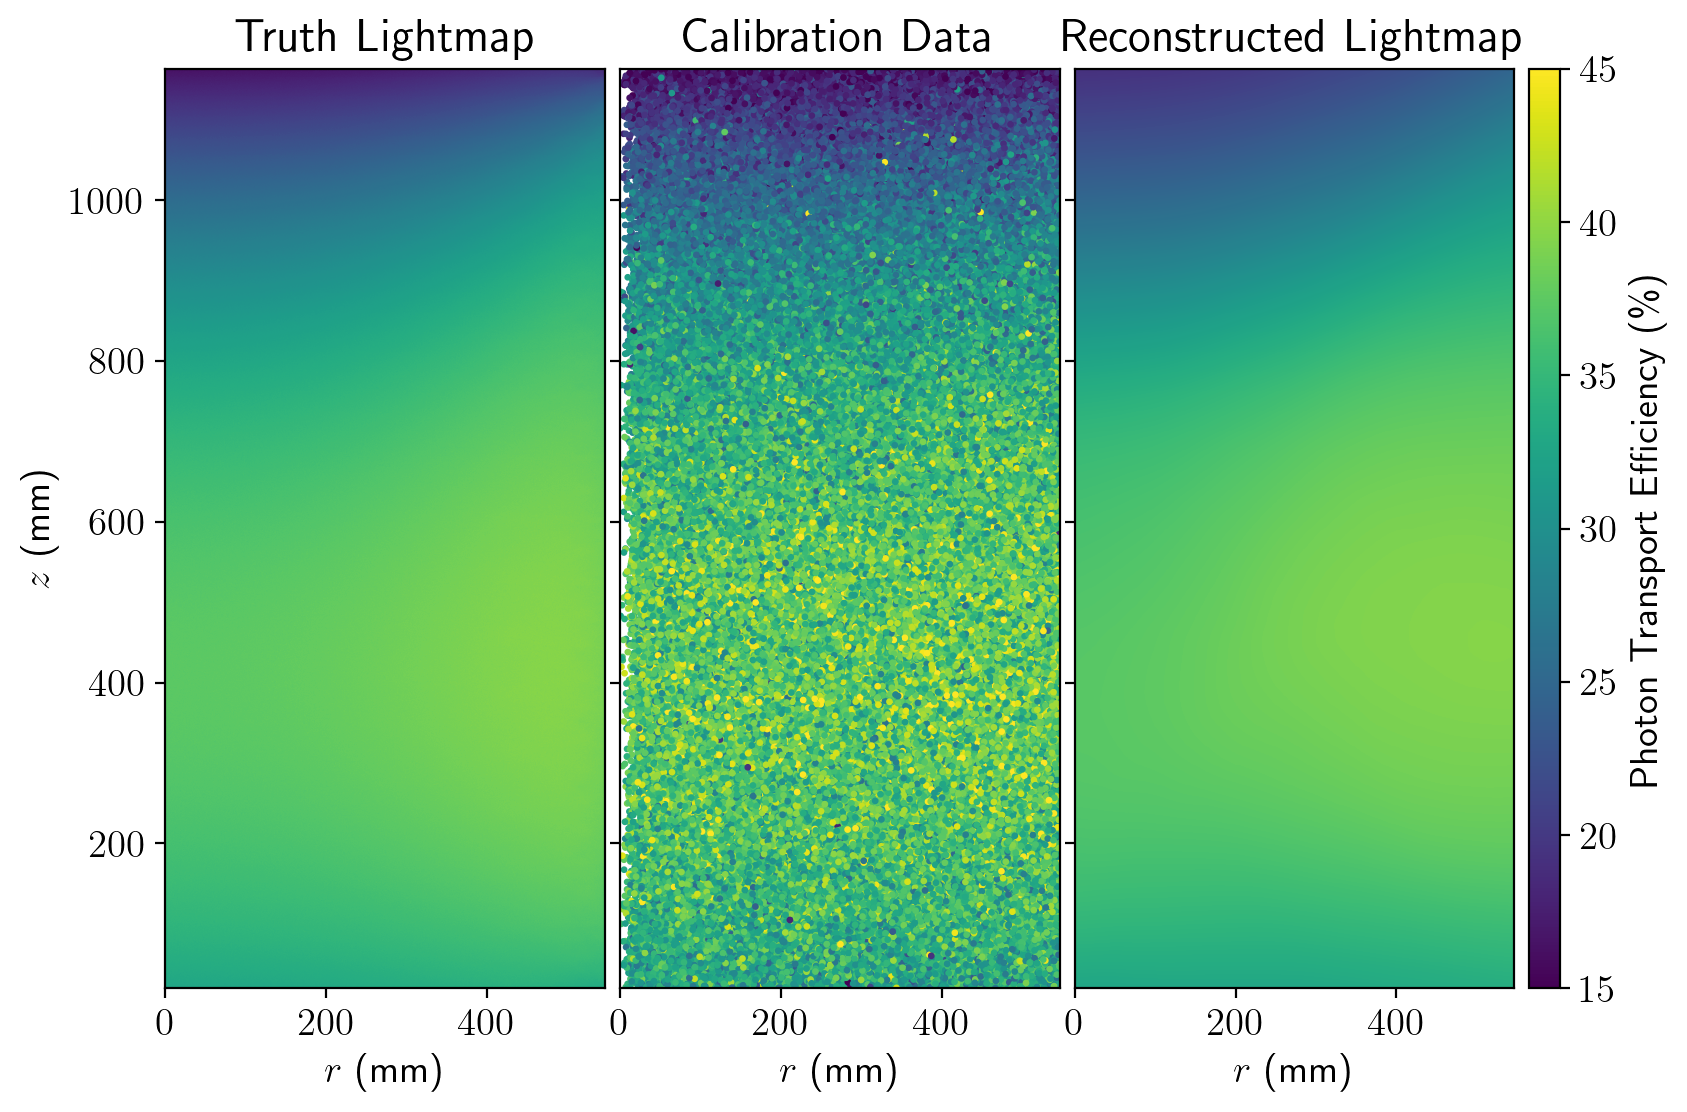

In [19]:
# get data from sample dataset to plot
weighted_radius,z,eff,tpc_r,tpc_zmin,tpc_zmax, xvals, yvals, num_thermal_electrons, \
    num_init_optical_phot, evt_charge_incl_noise, observed_light, x_values, y_values, z_values \
    = pickle.load(open('../Lightmap/sample_data_thesis_figs.pkl','rb'))
result_file = '/p/lustre2/nexouser/hardy27/xe127_sims//outputs/paper_plot_results.pkl'
result = gzip.open(result_file,'rb')
this_df = pickle.load(result)

# shift the histograms to put the cathode at 0 for plotting
offset = -this_df['hist_true'][0].bins[1][0]
this_df['hist_true'][0].bins[1] = this_df['hist_true'][0].bins[1]+offset
this_df['hist_again'][0].bins[1] = this_df['hist_again'][0].bins[1]+offset

# create a grid to show the stages of simulation and reconstruction
gridspec_kw = {'width_ratios':[1,1,1,1]}
fig=plt.figure(figsize=(9,6))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,3),
                 axes_pad=0.075,
                 share_all=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.075,
                 label_mode='L'
                 )

# add plots to the three panels
ht = hl.plot2d(grid[0],100*this_df['hist_true'][0], cbar=False, cmap='viridis',vmin=15,vmax=45)
sc = grid[1].scatter(weighted_radius,z+offset,c=100*eff,s=2,cmap='viridis',vmin=15,vmax=45)
ha = hl.plot2d(grid[2],100*this_df['hist_again'][0], cbar=False, cmap='viridis',vmin=15,vmax=45)

# save the data for this plot so it can be loaded and replotted for my thesis
h_true = this_df['hist_true'][0]
h_recon = this_df['hist_again'][0]
np.savez('lm_calibration_sim_pipeline.npz', true_lm_r_bins=h_true.bins[0], true_lm_z_bins=h_true.bins[1], true_lm_eff=h_true.values.T, \
                                            cal_datapoints_r=weighted_radius, cal_datapoints_z=z + offset, cal_datapoints_eff=eff, \
                                            recon_lm_r_bins=h_recon.bins[0], recon_lm_z_bins=h_recon.bins[1], recon_lm_eff=h_recon.values.T, \
                                            tpc_r=tpc_r, tpc_zmin=tpc_zmin, tpc_zmax=tpc_zmax, allow_pickle=False)

# set plot sizes
for ax in grid:
    ax.set_xlim([0,tpc_r-20])
    ax.set_ylim([tpc_zmin+20+offset,tpc_zmax-20+offset])
    ax.set_aspect('equal')
    ax.set_xlabel(r'$r$ (mm)')

# set titles etc
grid[0].set_title('Truth Lightmap')
grid[0].set_ylabel(r'$z$ (mm)')
grid[1].set_title('Calibration Data')
grid[2].set_title('Reconstructed Lightmap')
bounds = [15,20,25,30,35,40,45]
ticks = np.linspace(bounds[0],bounds[-1], len(bounds))
cbar = grid[2].cax.colorbar(ha,ticks=ticks)
cbar.set_label(r'Photon Transport Efficiency (\%)')
grid[2].cax.toggle_label(True)
# fig.savefig('sample_calibration.png',bbox_inches='tight')
plt.show()

### Save some sample data used to make the normal diagnostic plots

In [ ]:
lm_true = LightMap.load_model(folder+'/../true-lm', 'LightMapHistRZ')
truth_hist,truth_bins = np.histogram(num_init_optical_phot,bins=100)
det_hist,det_bins = np.histogram(observed_light,bins=100)
truth_bins = (truth_bins[1:]+truth_bins[:-1])/2.
det_bins = (det_bins[1:]+det_bins[:-1])/2.
scale = truth_bins[np.argmax(truth_hist)]/det_bins[np.argmax(det_hist)]
observed_light_scaled = observed_light*scale
corrected_perfect_lm = observed_light/0.186/lm_true(x_values,y_values,z_values)

np.savez('sim_data_xe127.npz', peak_cut_x=xvals, peak_cut_y=yvals, num_thermal_electrons=num_thermal_electrons, \
                               num_init_optical_phot=num_init_optical_phot, evt_charge_incl_noise=evt_charge_incl_noise, \
                               observed_light=observed_light, observed_light_scaled=observed_light_scaled, \
                               corrected_perfect_lm=corrected_perfect_lm, allow_pickle=False)

<- /p/lustre2/nexouser/hardy27/xe127_sims/outputs//../true-lm/LightMapHistRZ/model.npy ...
